In [1]:
import sympy as sym
import numpy as np
import scipy as sp
from scipy import linalg, spatial


import matplotlib.pyplot as plt

In [2]:
#create array of numbers from 1 to 1000
A1 = np.arange(1,1001)

### Analitična izpeljava - 1D

In [3]:
x,L,A,ρ,E,I,α = sym.symbols('x,L,A,ρ,E,I,α')

# vektor monomov
monomi = sym.lambdify(x, sym.Matrix([[1,x]]), 'sympy')
monomi(x)

Matrix([[1, x]])

In [4]:
# vektor oblikovnih funkcij
Ne = monomi(x) @ sym.Matrix([monomi(0),monomi(L)])**-1
Ne

Matrix([[1 - x/L, x/L]])

In [5]:
# odvodi oblikovnih funkcij
Be = sym.diff(Ne,x,1)
Be

Matrix([[-1/L, 1/L]])

In [6]:
# masna matrika
Me = sym.integrate(A*ρ* Ne.T @ Ne,(x,0,L))
Me

Matrix([
[A*L*ρ/3, A*L*ρ/6],
[A*L*ρ/6, A*L*ρ/3]])

In [7]:
# togostna matrika
Ke = sym.integrate(E*A* Be.T @ Be,(x,0,L))
Ke

Matrix([
[ A*E/L, -A*E/L],
[-A*E/L,  A*E/L]])

# Numerična obravnava

### Generacija masne in togostne matrike

In [8]:
# podatki
A = 100 # mm^2
ρ = 7.85e-9 # kg/mm^3
E = 2.0e5 # MPa
L0 = 1000 # mm

In [9]:
# masna matrika
def M_e(A, L, ρ):

    M = ρ*A*L/6*np.array([
    [2, 0, 1, 0],
    [0, 2, 0, 1],
    [1, 0, 2, 0],
    [0, 1, 0, 2]])
    
    return M

In [10]:
# togostna matrika
def K_e(A, E, L, α):

    c = np.cos(α)
    s = np.sin(α)
    
    K = A*E/L*np.array([
    [ c**2,   s*c, -c**2,  -s*c],
    [  s*c,  s**2,  -s*c, -s**2],
    [-c**2,  -s*c,  c**2,   s*c],
    [ -c*s, -s**2,   s*c,  s**2]])
    
    return K

(-100.0, 1200.0)

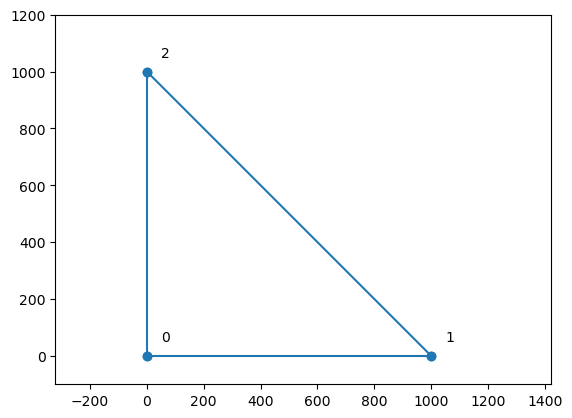

In [11]:
# vozlišča in elementi
vozlisca = L0*np.array([[0, 0], [1, 0], [0, 1]])
elementi = np.array([[0, 1], [1, 2], [2, 0]])

# [plt.plot(vozlisca[[i,j],0],vozlisca[[i,j],1],'-',c='C0') for i,j in elementi]
# plt.plot(vozlisca[:,0],vozlisca[:,1],'o');
# plt.axis('equal');

for i, j in elementi:
    plt.plot(vozlisca[[i, j], 0], vozlisca[[i, j], 1], '-o', c='C0')
    plt.annotate(i, (vozlisca[i, 0]+50, vozlisca[i, 1]+50))
plt.axis('equal')
plt.xlim(-100, 1200)
plt.ylim(-100, 1200)


### Definicija dolžin

In [12]:
def length(v1, v2):
    return np.sqrt((v1[0] - v2[0])**2 + (v1[1] - v2[1])**2)

dolzine = np.zeros(len(elementi))
for i in elementi:
    dolzine[i] = length(vozlisca[i[0]], vozlisca[i[1]])

### Definicija kotov naklona

In [13]:
def kotAlpha(i):
    """podaj samo indeks elementa, katerega kot iščeš"""
    K1 = elementi[i][0]
    K2 = elementi[i][1]
    y = np.array([[vozlisca[K1][1], vozlisca[K2][1]]])
    x = np.array([[vozlisca[K1][0], vozlisca[K2][0]]])
    dy = y[0][1] - y[0][0]
    dx = x[0][1] - x[0][0]
    k = np.arctan2(dy, dx, out=None)
    # print(dy, dx)
    return k

koti_lok = np.zeros(len(elementi))
koti_lok_deg = np.zeros_like(koti_lok)

for i in np.arange(len(elementi)):
    koti_lok[i] = kotAlpha(i)
for i in np.arange(len(elementi)):
    koti_lok_deg[i] = 180*koti_lok[i]/np.pi
print(koti_lok)
print(koti_lok_deg)

[ 0.          2.35619449 -1.57079633]
[  0. 135. -90.]


In [14]:
print(f'Dolžine: \t Kot naklona: ')
for i in np.arange(len(elementi)):
    print(f'{dolzine[i]:.3f} \t {koti_lok[i]:.3f}')
    

Dolžine: 	 Kot naklona: 
1000.000 	 0.000
1414.214 	 2.356
1000.000 	 -1.571


## Definicija M in K elementov

In [15]:
# for i in np.arange(len(elementi)):
#     M_i = M_e(A, dolzine[i], ρ)
#     print(f'M_{i} : \n {M_i} \n\n')
    
# for i in np.arange(len(elementi)):
#     K_i = K_e(A, E, dolzine[i], koti_lok[i])
#     print(f'K_{i} : \n {K_i} \n\n')

In [30]:
def prikaz(A):
    for i in A:
        print(f'{i}')

In [31]:
M_0 = M_e(A, dolzine[0], ρ)
M_1 = M_e(A, dolzine[1], ρ)
M_2 = M_e(A, dolzine[2], ρ)
K_0 = K_e(A, E, dolzine[0], koti_lok[0])
K_1 = K_e(A, E, dolzine[1], koti_lok[1])
K_2 = K_e(A, E, dolzine[2], koti_lok[2])

In [93]:
#Indexi
def Index(i):
    I = np.zeros(4)
    I[0] = int(2 * elementi[i][0])
    I[1] = int(2 * elementi[i][0] + 1)
    I[2] = int(2 * elementi[i][1])
    I[3] = int(2 * elementi[i][1] + 1)
    # print(I)
    return I.astype(int)

In [42]:
prikaz(M_2)

[0.00026167 0.         0.00013083 0.        ]
[0.         0.00026167 0.         0.00013083]
[0.00013083 0.         0.00026167 0.        ]
[0.         0.00013083 0.         0.00026167]


In [94]:
I0 = np.array(Index(0))
I1 = np.array(Index(1))
I2 = np.array(Index(2))

# print(I0)
# print(I1)
# print(I2)
# I0[:, None]
I0

array([0, 1, 2, 3])

In [98]:
# sestavljanje globalne masne in togostne matrike
M_glob = np.zeros((vozlisca.size,vozlisca.size))
K_glob = np.zeros((vozlisca.size,vozlisca.size))

# peški polnjenje M_glob
M_glob[I0[:, None], I0] += M_0
M_glob[I1[:, None], I1] += M_1[i, i]
M_glob[I2[:, None], I2] += M_2[i, i]
    
K_glob[I0[:, None], I0] += K_0
K_glob[I1[:, None], I1] += K_1[i, i]
K_glob[I2[:, None], I2] += K_2[i, i]

print(M_glob)
print()
print(K_glob)

[[0.00052333 0.00026167 0.00013083 0.         0.00026167 0.00026167]
 [0.00026167 0.00052333 0.         0.00013083 0.00026167 0.00026167]
 [0.00013083 0.         0.00063172 0.00037005 0.00037005 0.00037005]
 [0.         0.00013083 0.00037005 0.00063172 0.00037005 0.00037005]
 [0.00026167 0.00026167 0.00037005 0.00037005 0.00063172 0.00063172]
 [0.00026167 0.00026167 0.00037005 0.00037005 0.00063172 0.00063172]]

[[ 2.00000000e+04  7.49879891e-29 -2.00000000e+04  0.00000000e+00
   7.49879891e-29  7.49879891e-29]
 [ 7.49879891e-29  7.49879891e-29  0.00000000e+00  0.00000000e+00
   7.49879891e-29  7.49879891e-29]
 [-2.00000000e+04  0.00000000e+00  2.70710678e+04  7.07106781e+03
   7.07106781e+03  7.07106781e+03]
 [ 0.00000000e+00  0.00000000e+00  7.07106781e+03  7.07106781e+03
   7.07106781e+03  7.07106781e+03]
 [ 7.49879891e-29  7.49879891e-29  7.07106781e+03  7.07106781e+03
   7.07106781e+03  7.07106781e+03]
 [ 7.49879891e-29  7.49879891e-29  7.07106781e+03  7.07106781e+03
   7.07106781

In [76]:
MM = np.arange(16)
MM = MM.reshape(4,4)
ind = np.array([0, 1, 2, 3])
ind1 = np.array([2,3,4,5])
ind2 = np.array([4,5,0,1])
print(MM)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


In [80]:
M_glob = np.zeros((vozlisca.size,vozlisca.size))
M_glob[ind2[:,None], ind2] = MM
print(M_glob)

[[10. 11.  0.  0.  8.  9.]
 [14. 15.  0.  0. 12. 13.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 2.  3.  0.  0.  0.  1.]
 [ 6.  7.  0.  0.  4.  5.]]


numpy.delete()

## Robni pogoji

In [23]:
ind_ps = np.arange(6)
ind_vpetih = np.array([0, 1, 3])

M_glob_ = np.delete(M_glob, ind_vpetih, axis=0)
M_glob_ = np.delete(M_glob_, ind_vpetih, axis=1)
M_glob_


array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [24]:
ind_prosti_ps = np.setdiff1d(ind_ps, ind_vpetih)

M_glob_rp = M_glob(ind_prosti_ps[:,None], ind_prosti_ps)
K_glob_rp = K_glob(ind_prosti_ps[:,None], ind_prosti_ps)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
# a) vpnemo vozlisce 0 v x in y smeri
# b) vpemo vozlisce 1 v y smeri

# Opcija 1 - brisanje vrstic in stolpcev
ind_ps = np.arange(vozlisca.size)
ind_vpetih_ps = np.array([0,1,3])
ind_prostih_ps = np.setdiff1d(ind_ps, ind_vpetih_ps)

M_glob_rp = M_glob[ind_prostih_ps[:,None],ind_prostih_ps]
K_glob_rp = K_glob[ind_prostih_ps[:,None],ind_prostih_ps]


# Opcija 2 - C in L
C = np.array([
    #0   1   2   3   4   5
    [1,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0]
])

L = np.block(sym.Matrix(C).nullspace()).astype(int)

M_glob_c = L.T @ M_glob @ L
K_glob_c = L.T @ K_glob @ L

### Reševanje problema lastnih vrednosti

In [ ]:
# lastne vrednosti in lastni vektorji
eig_val, eig_vec = sp.linalg.eig(K_glob, M_glob)

# urejanje po velikosti - dopolniti

NameError: name 'modeshape' is not defined

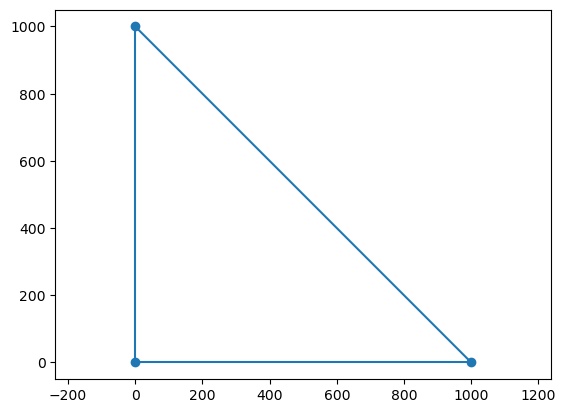

In [ ]:
# izris lastnih oblik

# nedeformirano stanje
[plt.plot(vozlisca[[i,j],0],vozlisca[[i,j],1],'-', c='C0') for i,j in elementi]
plt.plot(vozlisca[:,0],vozlisca[:,1],'o', c='C0');
plt.axis('equal');

# deformirano stanje
[plt.plot(modeshape[[i,j],0],modeshape[[i,j],1],'-', c='C1') for i,j in elementi]
plt.plot(modeshape[:,0],modeshape[:,1],'o', c='C1');
plt.axis('equal');

### Sprememba robnih pogojev